## Ensemble Learning

- Ensemble models: motivation, principles and model types
- Random forest classifier
- ROC classifier scoring
- Boosting algorithms:
    - Adaboost
    - Gradient boost

#### Resources:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

https://scikit-learn.org/stable/modules/ensemble.html

https://xgboost.readthedocs.io/en/stable/


#### Motivation for Ensemble Learning:

- **Bias and Variance:** Key concepts in understanding model performance.
- **Limiting Model Variance:** Regularization techniques like Ridge and Lasso help control variance.
- **Regression Algorithms:** High bias due to strong assumptions, suitable for regularization.
- **Non-Parametric Learning Algorithms:** Examples include Trees and KNN, which exhibit low bias but high variance.
- **Understanding Variance:** Variance is how a model's performance changes with resampling.
- **Ensemble Learning:** 
  - Combats variance by training multiple models on resampled data.
  - More broadly, uses multiple models to balance both bias and variance.
- **Model Diversity:** 
  - Individual models capture different data patterns.
  - Instead of one complex model, use many simple models.
  - Combine these models to achieve a collective prediction, compensating for individual variances and biases.

### Key Vocabulary and Ensemble Types

#### Ensemble Types:
- **Voting**
- **Bagging**
- **Boosting**

#### Bagging (Bootstrap Aggregating) vs. Simple Random Sampling:
  - Bootstrapping involves sampling with replacement.
  - Simple random sampling does not use replacement.

#### Voting:

  - Train multiple models using the same or different algorithms.
  - Predict using majority rule (classifiers) or averaging (regression) on individual predictions.

#### Bagging:

  - Resample training data using bootstrapping (sampling with replacement) multiple times.
  - Train a model on each bootstrap sample, optionally using a random subset of features.
  - Use voting for final prediction.

#### Boosting:

  - Focus on misclassified data points (classification) or high MSE points (regression).
  - Adaptive Boosting (AdaBoost): Each subsequent model gives higher importance to misclassified data or residuals.
  - Gradient Boosting: Each subsequent model focuses solely on misclassified data or residuals.

#### Note:
- **Applicability:**
  - Ensemble approaches can be used for both classification and regression tasks.
  
- **Execution:**
  - Bagging: Ensemble members are independent and can be executed in parallel or in any order.
  - Boosting: Iterative process where each model depends on the previous iteration.

- **Analogies:**
  - Voting/Bagging: Similar to crowdsourcing.
  - Boosting: Comparable to hiring a consultant to tackle difficult problems.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Random Forests

### Understanding Random Forests

- Random forest is an ensemble of decision or regression trees, the most popular ensemble algorithm.
- **Aggregation Method:** Utilizes bagging (Bootstrap Aggregating) to train multiple tree estimators on bootstrapped samples of the training data, reducing inherent variance.
- **Feature Selection:** Each estimator can use a random subset of features rather than the entire feature set, enhancing model robustness.

#### Example: Insurance dataset

In [2]:
## data import, feature encoding and scaling, splitting (code inherited from prevuous labs):

df = pd.read_csv('../data/insurance2.csv')
df['region'] = df['region'].astype('str')
y = df['insuranceclaim']
df=df.drop(columns = ['insuranceclaim'])
df = pd.get_dummies(data = df, drop_first = True)
features = df.columns
X = df.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

- Baseline: logistic regression model:

In [3]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test))[:220])
confusion_matrix(y_test, lr.predict(X_test))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       161
           1       0.89      0.88      0.89       241

    accuracy                           0.87       402
  


array([[135,  26],
       [ 28, 213]], dtype=int64)

- Random forest with default hyperparameters

In [4]:
rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_train,y_train)
print(classification_report(y_test, rfc.predict(X_test))[:220])
confusion_matrix(y_test, rfc.predict(X_test))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       161
           1       0.95      0.93      0.94       241

    accuracy                           0.93       402
  


array([[148,  13],
       [ 17, 224]], dtype=int64)

- Random forest improves accuracy and positive recall
- Hyperparameters:
    - n_estimators
    - criterion (“gini”, “entropy”, “log_loss”)
    - max_depth
    - ...

- Feature ranking by their importance for the random forest model

In [5]:
pd.Series(rfc.feature_importances_, index = features).sort_values(ascending=False)

bmi         0.353150
children    0.261982
charges     0.159094
age         0.097908
smoker      0.093030
sex         0.009495
region_2    0.008970
region_1    0.008887
region_3    0.007484
dtype: float64

- Feature ranking using logistic regression coefficient magnitudes

In [6]:
pd.Series(abs(lr.coef_[0]), index = features).sort_values(ascending=False)

bmi         5.982402
children    4.934425
smoker      2.830037
age         1.005291
charges     0.767279
region_1    0.381897
region_3    0.274483
region_2    0.136031
sex         0.052221
dtype: float64

## ROC (receiver operating characteristic) and AUC (area under curve)

- Scoring a classifier is more intricate compared to a regressor.
- **Classification Metrics:** Most metrics focus on specific aspects of a classifier; unlike MSE in regression, there's no universal metric.
- **ROC Curve:** Represents true positive rate (recall) vs false positive rate (ratio of false positives to all negatives).
- **Threshold and ROC:** ROC is generated by adjusting the classification threshold between 0 and 1; classifiers like KNN without thresholds can only exhibit a 3-point ROC curve.
- **Predict_proba() Method:** A classifier with .predict_proba() allows constructing a meaningful ROC curve.
- **Interpreting ROC:** A steep ROC curve indicates a good classifier, while one closer to the diagonal (representing random guessing) indicates a poor classifier.
- **Area Under Curve (AUC):** AUC is 0.5 for random guessing and 1.0 for an ideal classifier.

#### ROC curves for LR and RF classifiers

In [7]:
roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
# roc_curve returns a tuple of three arrays: false_positive_rate, true_positive_rate, thresholds

(array([0.        , 0.        , 0.        , 0.00621118, 0.00621118,
        0.01863354, 0.01863354, 0.02484472, 0.02484472, 0.0310559 ,
        0.0310559 , 0.03726708, 0.03726708, 0.04347826, 0.04347826,
        0.04968944, 0.04968944, 0.05590062, 0.05590062, 0.0621118 ,
        0.0621118 , 0.06832298, 0.06832298, 0.07453416, 0.07453416,
        0.08074534, 0.08074534, 0.09937888, 0.09937888, 0.10559006,
        0.10559006, 0.11180124, 0.11180124, 0.1242236 , 0.1242236 ,
        0.13043478, 0.13043478, 0.13664596, 0.13664596, 0.16149068,
        0.16149068, 0.16770186, 0.16770186, 0.18012422, 0.18012422,
        0.19875776, 0.19875776, 0.21118012, 0.21118012, 0.37267081,
        0.37267081, 0.39130435, 0.39130435, 0.40993789, 0.40993789,
        0.45962733, 0.45962733, 0.55279503, 0.55279503, 0.60869565,
        0.60869565, 0.65217391, 0.65217391, 0.70807453, 0.70807453,
        0.75776398, 0.75776398, 0.77639752, 0.77639752, 0.83850932,
        0.83850932, 0.85714286, 0.85714286, 0.86

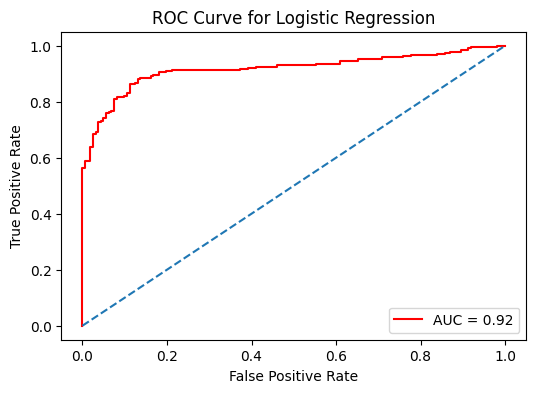

In [8]:
fpr_lr, tpr_lr, thr_lr = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 4))
plt.title('ROC Curve for Logistic Regression')
plt.plot(fpr_lr, tpr_lr, color='red',label = 'AUC = %0.2f' % roc_auc_lr)
#plt.plot(false_positive_rate[1:],thresholds[1:], color='black',label = 'threshold')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

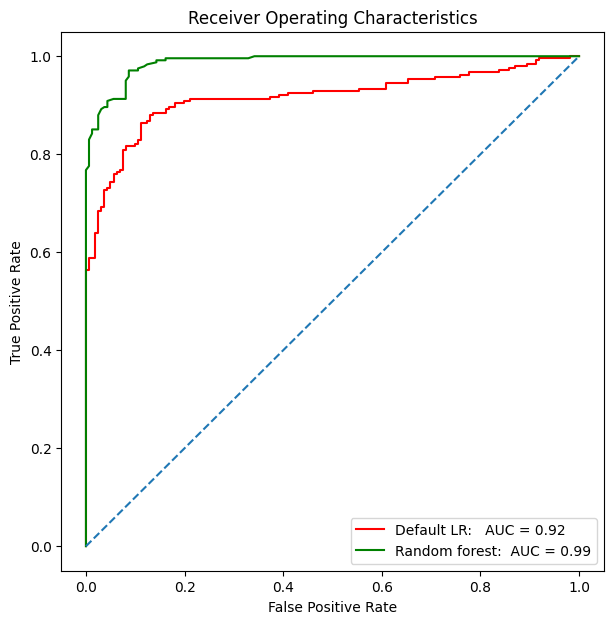

In [9]:
fpr_rf, tpr_rf, thr_rf = roc_curve(y_test, rfc.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7, 7))
plt.title('Receiver Operating Characteristics')
plt.plot(fpr_lr, tpr_lr, color='red',label = 'Default LR:   AUC = %0.2f' % roc_auc_lr)
plt.plot(fpr_rf,tpr_rf, color='green',label = 'Random forest:  AUC = %0.2f' % roc_auc_rf)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc = 'lower right')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Threshold optimization

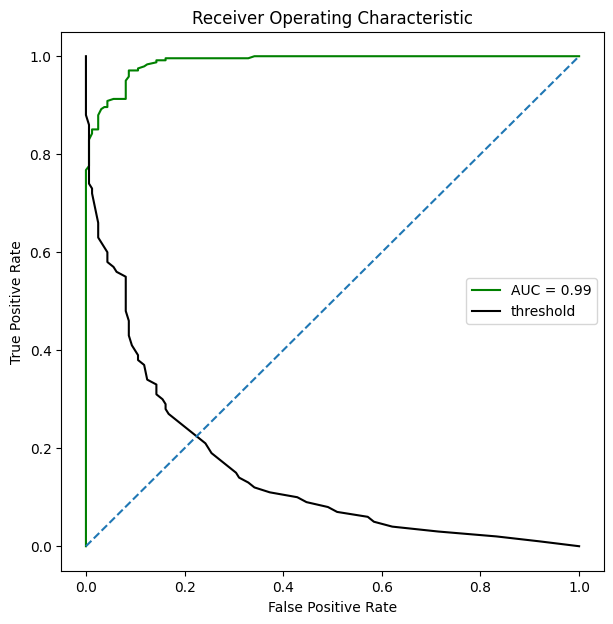

In [10]:
plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf, tpr_rf, color='green',label = 'AUC = %0.2f' % roc_auc_rf)
plt.plot(fpr_rf[1:],thr_rf[1:], color='black',label = 'threshold')
plt.legend(loc = 'right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [11]:
prob = rfc.predict_proba(X_test)[:, 1]

In [12]:
precision = []
recall = []
for thr in thr_rf[1:]:
    y_pred = (prob > thr).astype('int')
    tp = ((y_pred == 1) & (y_test == 1)).sum()
    fp = ((y_pred == 1) & (y_test == 0)).sum()
    fn = ((y_pred == 0) & (y_test == 1)).sum()
    precision.append(tp/(tp + fp))
    recall.append(tp/(tp + fn))

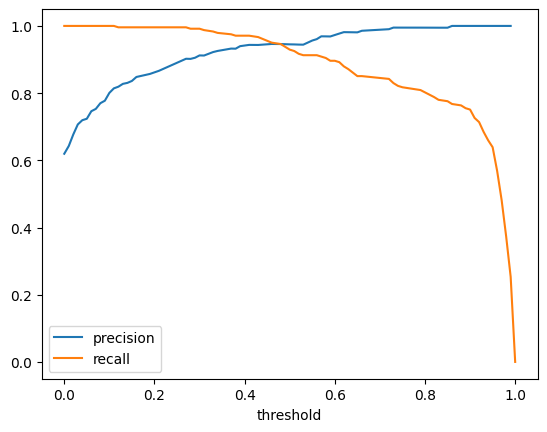

In [13]:
plt.plot(thr_rf[1:], precision, label = 'precision')
plt.plot(thr_rf[1:], recall, label = 'recall')
plt.legend()
plt.xlabel("threshold");

## Adaboost (Adaptive Boosting)

<img src="../images/adaboost.png" alt="Bias and Variance" width="600" height="600">
 

- AdaBoost is an ensemble learning method that builds a sequence of weak learners (typically, the estimators are decision trees or "stumps", i.e., single-split trees) with a focus on instances that previous models misclassified.
- Each subsequent model pays more attention to previously misclassified data points. Misclassified data is assigned higher weight, so each new iteration is trying to fix misclassification from the previous iteration
- The objective is reducing bias and variance simultaneously.
- **Final Prediction** combines predictions from all weak learners to form a strong classifier.


In [14]:
abc = AdaBoostClassifier(random_state = 42)
abc.fit(X_train,y_train)
print(classification_report(y_test, abc.predict(X_test))[:220])
confusion_matrix(y_test, abc.predict(X_test))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       161
           1       0.89      0.87      0.88       241

    accuracy                           0.86       402
  


array([[136,  25],
       [ 31, 210]], dtype=int64)

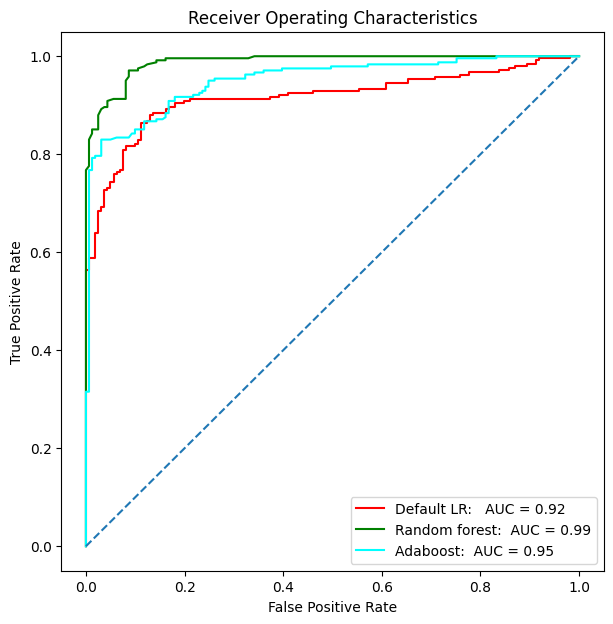

In [15]:
fpr_ab, tpr_ab, thr_ab = roc_curve(y_test, abc.predict_proba(X_test)[:, 1])
roc_auc_ab = auc(fpr_ab, tpr_ab)


plt.figure(figsize=(7, 7))
plt.title('Receiver Operating Characteristics')
plt.plot(fpr_lr, tpr_lr, color='red',label = 'Default LR:   AUC = %0.2f' % roc_auc_lr)
plt.plot(fpr_rf,tpr_rf, color='green',label = 'Random forest:  AUC = %0.2f' % roc_auc_rf)
plt.plot(fpr_ab, tpr_ab, color='cyan',label = 'Adaboost:  AUC = %0.2f' % roc_auc_ab)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc = 'lower right')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Gradient Boosting:

- Gradient Boosting builds a sequence of decision trees where each tree corrects errors made by the previous one.
- Optimizes a loss function by adding new models that minimize the loss gradient.
- Handles noisy data well by focusing on reducing residual errors iteratively.
- Typically uses deeper trees, leading to higher model complexity.
- **Difference from AdaBoost:** Focuses on optimizing a general loss function through gradient descent, whereas AdaBoost adjusts weights based on misclassification.
  
### XGBoost:

- XGBoost (Extreme Gradient Boosting) is an optimized implementation of gradient boosting:
   - Supports regularization to prevent overfitting.
   - Uses advanced algorithms for faster execution compared to traditional gradient boosting.
   - Can handle large datasets and is highly scalable.
   - Widely used in competitive machine learning for its performance and flexibility.
  

### Simulated dataset

In [16]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x}).to_numpy()
y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))

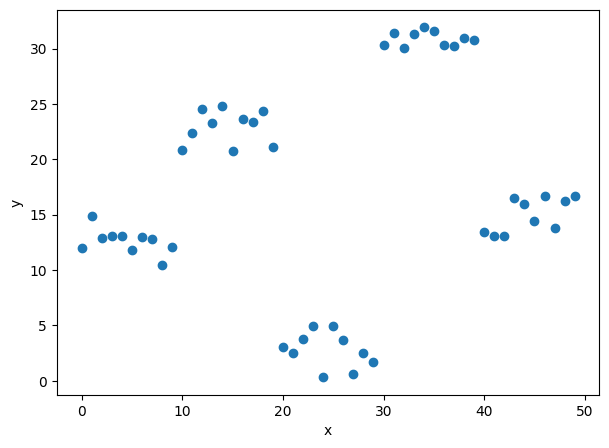

In [17]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [18]:
gbr = GradientBoostingRegressor(n_estimators = 3)
gbr.fit(x,y)
mean_squared_error(y, gbr.predict(x))

49.59866800866641

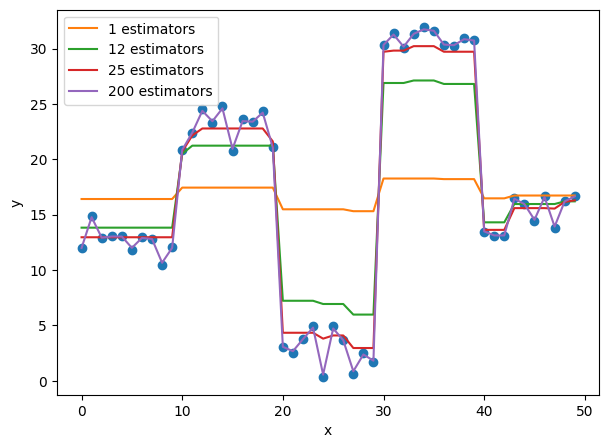

In [19]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.xlabel("x")
plt.ylabel("y")
for i in [1, 12, 25, 200]:
    gbr = GradientBoostingRegressor(n_estimators = i)
    gbr.fit(x,y)
    plt.plot(gbr.predict(x), label = f'{i} estimators')
plt.legend()
plt.show()

### Residual error (MSE) decreases with each new estimator

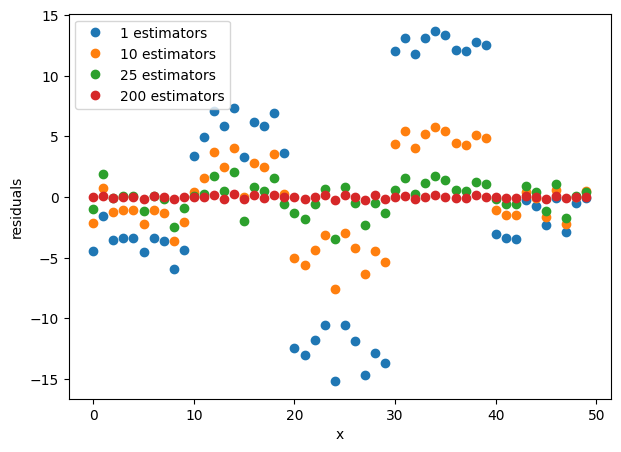

In [20]:
plt.figure(figsize=(7,5))

for i in [1, 10, 25, 200]:
    gbr = GradientBoostingRegressor(n_estimators = i)
    gbr.fit(x,y)
    plt.plot(x,(y - gbr.predict(x)), 'o', label = f'{i} estimators')
plt.legend()
plt.xlabel("x")
plt.ylabel("residuals")
plt.show()

**n_estimators is a hyperparameter**

In [21]:
x = np.arange(0,500)
x = pd.DataFrame({'x':x}).to_numpy()
y1 = np.random.uniform(10,15,100)
y2 = np.random.uniform(20,25,100)
y3 = np.random.uniform(0,5,100)
y4 = np.random.uniform(30,32,100)
y5 = np.random.uniform(13,17,100)

y = np.concatenate((y1,y2,y3,y4,y5))


X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.6, random_state=42)

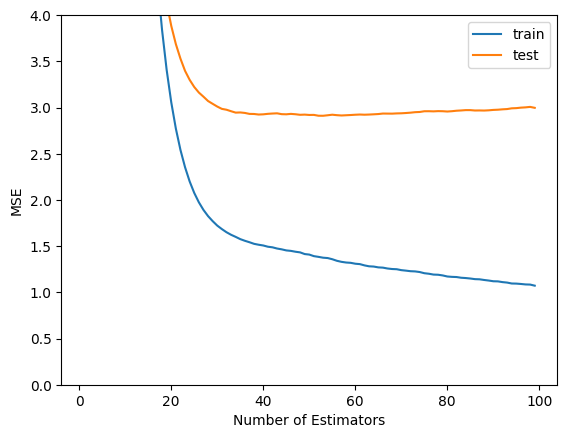

In [22]:
mse_train = []
mse_test = []

for i in range(1, 100):
    gbr = GradientBoostingRegressor(n_estimators = i, random_state=15)
    gbr.fit(X_train,y_train)
    mse_test.append(mean_squared_error(y_test, gbr.predict(X_test)))
    mse_train.append(mean_squared_error(y_train, gbr.predict(X_train)))

plt.plot(range(1, 100), mse_train, label = 'train')
plt.plot(range(1, 100), mse_test, label = 'test')
plt.ylim(0, 4)
plt.xlabel('Number of Estimators')
plt.ylabel("MSE")
plt.legend()
plt.show()

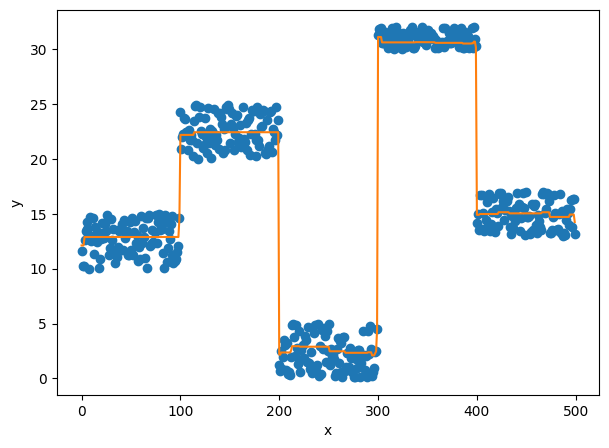

In [23]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.xlabel("x")
plt.ylabel("y")
gbr = GradientBoostingRegressor(n_estimators = 35, random_state=15)
gbr.fit(x,y)
plt.plot(gbr.predict(x))
plt.show()

### Summary


- Ensemble models: motivation, principles and model types
- Random forest classifier
- ROC classifier scoring
- Boosting algorithms:
    - Adaboost
    - Gradient boost